# Popularity based model

## Part 1: Import libraries and dataset

In [2]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import matplotlib.pyplot as plt

In [52]:
retail_data_original = pd.read_excel (r'D:/Internship-2020/ROBOKEN-internship/Recommendation-system/Datset/Online Retail Original.xlsx')

## Part 2: Cleaning and processing of the data

In [128]:
retail_data = retail_data_original
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Date,Time,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2010-12-01,08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,2010-12-01,08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2010-12-01,08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,2010-12-01,08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,2010-12-01,08:26:00,3.39,17850.0,United Kingdom


In [54]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   Date         541909 non-null  datetime64[ns]
 6   Time         541909 non-null  object        
 7   UnitPrice    541909 non-null  float64       
 8   CustomerID   406829 non-null  float64       
 9   Country      541909 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 41.3+ MB


### Table for Item name and its stock code

In [55]:
item_lookup = retail_data[['StockCode', 'Description']].drop_duplicates() # Only get unique item/description pairs
item_lookup['StockCode'] = item_lookup.StockCode.astype(str) # Encode as strings for future lookup ease

In [56]:
item_lookup.head()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


In [57]:
item_lookup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5752 entries, 0 to 540421
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StockCode    5752 non-null   object
 1   Description  4792 non-null   object
dtypes: object(2)
memory usage: 134.8+ KB


### Grouping purchase

Make a pivot table for every item, daywise sale

In [72]:
retail_data['StockCode'] = retail_data.StockCode.astype(str) # Convert to string for stock ID
retail_data = retail_data[['StockCode', 'Quantity', 'Time', 'Date','InvoiceDate']] # Get rid of unnecessary info
grouped_retail_buy_frequency = retail_data.groupby(['StockCode','Time', 'Date','InvoiceDate']).sum().reset_index() # Group together
grouped_retail_buy_frequency.Quantity.loc[grouped_retail_buy_frequency.Quantity == 0] = 1 # Replace a sum of zero purchases with a one to
# indicate purchased
grouped_purchased = grouped_retail_buy_frequency.query('Quantity > 0') # Only get customers where purchase totals were positive

C:\Users\test\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\test\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [73]:
grouped_purchased.head()

,StockCode,Time,Date,InvoiceDate,Quantity
0,10002,08:42:00,2010-12-06,2010-12-06 08:42:00,24
1,10002,08:45:00,2010-12-01,2010-12-01 08:45:00,48
2,10002,09:05:00,2011-01-19,2011-01-19 09:05:00,12
3,10002,09:09:00,2011-02-25,2011-02-25 09:09:00,24
4,10002,09:35:00,2010-12-13,2010-12-13 09:35:00,2


In [79]:
from pandas.api.types import CategoricalDtype
Products = list(np.sort(grouped_purchased.StockCode.unique())) # Get our unique products that were purchased
BuyDateandTime = list(grouped_purchased.InvoiceDate.unique()) # Get the date + time of purchase
BuyDate = list(grouped_purchased.Date.unique()) # Get the date of purchase
BuyTime = list(grouped_purchased.Time.unique()) # Get the Time of purchase
quantity = list(grouped_purchased.Quantity) # All of our purchases

#### Sparse plot for product vs date

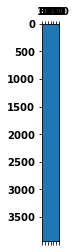

In [89]:
rows = grouped_purchased.StockCode.astype(CategoricalDtype(categories = Products)).cat.codes 
# Get the associated row indices
cols = grouped_purchased.Date.astype(CategoricalDtype(categories = BuyDate)).cat.codes 
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(Products), len(BuyDate)))
plt.spy(purchases_sparse)

In [90]:
import numpy as np
from tabulate import tabulate

table = tabulate(purchases_sparse, tablefmt="grid")
print(purchases_sparse.shape[0])
print(purchases_sparse.shape[1])

3940
305


In [91]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

76.96296912706998

#### Sparse plot for products vs time

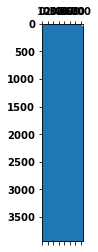

In [92]:
rows = grouped_purchased.StockCode.astype(CategoricalDtype(categories = Products)).cat.codes 
# Get the associated row indices
cols = grouped_purchased.Time.astype(CategoricalDtype(categories = BuyTime)).cat.codes 
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(Products), len(BuyTime)))
plt.spy(purchases_sparse)

In [93]:
import numpy as np
from tabulate import tabulate

table = tabulate(purchases_sparse, tablefmt="grid")
print(purchases_sparse.shape[0])
print(purchases_sparse.shape[1])

3940
741


In [94]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

86.94571747604074

#### Sparse plot for product vs date and time

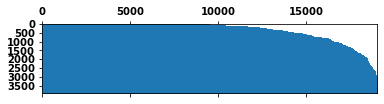

In [95]:
rows = grouped_purchased.StockCode.astype(CategoricalDtype(categories = Products)).cat.codes 
# Get the associated row indices
cols = grouped_purchased.InvoiceDate.astype(CategoricalDtype(categories = BuyDateandTime)).cat.codes 
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(Products), len(BuyDateandTime)))
plt.spy(purchases_sparse)

In [96]:
import numpy as np
from tabulate import tabulate

table = tabulate(purchases_sparse, tablefmt="grid")
print(purchases_sparse.shape[0])
print(purchases_sparse.shape[1])

3940
19044


In [97]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.30903400833976

## Grouping purchase Daywise

In [121]:
retail_data['StockCode'] = retail_data.StockCode.astype(str) # Convert to string for stock ID
retail_data = retail_data[['StockCode', 'Quantity', 'Time', 'Date','InvoiceDate']] # Get rid of unnecessary info
grouped_retail_buy_frequency = retail_data.groupby(['StockCode','Date']).sum().reset_index() # Group together
grouped_retail_buy_frequency.Quantity.loc[grouped_retail_buy_frequency.Quantity == 0] = 1 # Replace a sum of zero purchases with a one to
# indicate purchased
grouped_purchased = grouped_retail_buy_frequency.query('Quantity > 0') # Only get customers where purchase totals were positive

C:\Users\test\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [122]:
grouped_purchased.head()

,StockCode,Date,Quantity
0,10002,2010-12-01,60
1,10002,2010-12-02,1
2,10002,2010-12-03,8
3,10002,2010-12-05,1
4,10002,2010-12-06,25


In [123]:
from pandas.api.types import CategoricalDtype
Products = list(np.sort(grouped_purchased.StockCode.unique())) # Get our unique products that were purchased
BuyDate = list(grouped_purchased.Date.unique()) # Get the date of purchase
quantity = list(grouped_purchased.Quantity) # All of our purchases

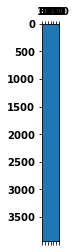

In [124]:
rows = grouped_purchased.StockCode.astype(CategoricalDtype(categories = Products)).cat.codes 
# Get the associated row indices
cols = grouped_purchased.Date.astype(CategoricalDtype(categories = BuyDate)).cat.codes 
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(Products), len(BuyDate)))
plt.spy(purchases_sparse)

In [125]:
import numpy as np
from tabulate import tabulate

table = tabulate(purchases_sparse, tablefmt="grid")
print(purchases_sparse.shape[0])
print(purchases_sparse.shape[1])

3939
305


## 1. Basic popularity based recommendation

In [181]:
retail_data_new = retail_data[['StockCode', 'Quantity']] # Get rid of unnecessary info

In [182]:
retail_data_new

,StockCode,Quantity
0,85123A,6
1,71053,6
2,84406B,8
3,84029G,6
4,84029E,6
...,...,...
541904,22613,12
541905,22899,6
541906,23254,4
541907,23255,4


In [183]:
retail_data_new = retail_data_new.groupby(['StockCode'])['Quantity'].agg('sum')
retail_data_new.size

4070

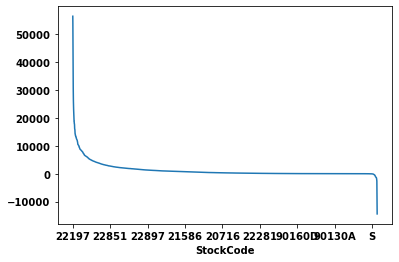

In [192]:
df = retail_data_new
df_popular = df.sort_values(ascending = False)
df.sort_values(ascending = False).plot()
plt.show()

### Output for popular items 

In [ ]:
def rec_items(customer_id, mf_train, user_vecs, item_vecs, customer_list, item_list, item_lookup, num_items = 10):
    '''
    This function will return the top recommended items to our users 
    
    parameters:
    
    customer_id - Input the customer's id number that you want to get recommendations for
    
    mf_train - The training matrix you used for matrix factorization fitting
    
    user_vecs - the user vectors from your fitted matrix factorization
    
    item_vecs - the item vectors from your fitted matrix factorization
    
    customer_list - an array of the customer's ID numbers that make up the rows of your ratings matrix 
                    (in order of matrix)
    
    item_list - an array of the products that make up the columns of your ratings matrix
                    (in order of matrix)
    
    item_lookup - A simple pandas dataframe of the unique product ID/product descriptions available
    
    num_items - The number of items you want to recommend in order of best recommendations. Default is 10. 
    
    returns:
    
    - The top n recommendations chosen based on the user/item vectors for items never interacted with/purchased
    '''
    
    cust_ind = np.where(customer_list == customer_id)[0][0] # Returns the index row of our customer id
    pref_vec = mf_train[cust_ind,:].toarray() # Get the ratings from the training set ratings matrix
    pref_vec = pref_vec.reshape(-1) + 1 # Add 1 to everything, so that items not purchased yet become equal to 1
    pref_vec[pref_vec > 1] = 0 # Make everything already purchased zero
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # Get dot product of user vector and all item vectors
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    recommend_vector = pref_vec*rec_vector_scaled 
    # Items already purchased have their recommendation multiplied by zero
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # Sort the indices of the items into order 
    # of best recommendations
    rec_list = [] # start empty list to store items
    for index in product_idx:
        code = item_list[index]
        rec_list.append([code, item_lookup.Description.loc[item_lookup.StockCode == code].iloc[0]]) 
        # Append our descriptions to the list
    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'StockCode': codes, 'Description': descriptions}) # Create a dataframe 
    return final_frame[['StockCode', 'Description']] # Switch order of columns around


In [194]:
Num = int(input('Enter the number of top popular recommendations you want: '))

Enter the number of top popular recommendations you want: 20


In [203]:
df_popular

StockCode
22197      56450
84077      53847
85099B     47363
85123A     38830
84879      36221
           ...  
79323LP    -2618
79323W     -4838
72140F     -5368
23003      -8516
23005     -14418
Name: Quantity, Length: 4070, dtype: int64

In [195]:
df_popular.head(Num)

StockCode
22197     56450
84077     53847
85099B    47363
85123A    38830
84879     36221
21212     36039
23084     30646
22492     26437
22616     26315
21977     24753
22178     23854
17003     23053
15036     22552
21915     22066
22386     21009
23203     20013
20725     18979
84946     18911
22086     18902
84991     18040
Name: Quantity, dtype: int64

## 2. Popular this month

In [205]:
retail_data_V2 = retail_data[['StockCode', 'Quantity', 'Date']] # Get rid of unnecessary info